In [1]:
from scipy.stats import norm, expon, uniform
from matplotlib import pyplot as plt
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns

In [2]:
def p_curve_lik(p, delta):
    '''
    probability mass function for a p-values of a 
    one-tailed Z-test
    '''
    Z = norm.isf(p, loc = 0)
    return norm.pdf(Z, loc = delta) / norm.pdf(Z, loc = 0)

p_curve_lik(.05, .2)

1.362022497242771

In [3]:
def p_curve_loglik(p, delta):
    Z = -pm.Normal.icdf(p, 0, 1)
    logp = pm.Normal.logp(Z, delta, 1) - pm.Normal.logp(Z, 0, 1)
    return logp

val = p_curve_loglik(.05, .2).eval()
print(np.exp(val))

1.362022497242771


In [4]:
pvals = [0.0005998800239952009,
 0.029994001199760048,
 0.04939012197560488,
 0.946010797840432]
pvals = np.array(pvals)

with pm.Model() as mixture_model:

    prior_mean = 1.5 # see prior predictive power simulation below
    delta = pm.Exponential('effect_size_arbitrary_scale', 1/prior_mean)
    pcurve_H1 = pm.CustomDist.dist(delta, logp = p_curve_loglik)
    pcurve_H0 = pm.Uniform.dist(0, 1)
    
    prev = pm.Uniform('prevalence', 0, 1)
    
    pm.Mixture(
        'likelihood', 
        w = [1 - prev, prev], 
        comp_dists = [pcurve_H0, pcurve_H1], 
        observed = pvals
    )
    idata = pm.sample(
        chains = 5, 
        cores = 5, 
        random_seed = 0,
        idata_kwargs = {'log_likelihood': True},
        target_accept = .95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size_arbitrary_scale, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 9 seconds.


Output()

In [5]:
az.summary(idata, hdi_prob = .95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effect_size_arbitrary_scale,2.02,0.710,0.609,3.395,0.015,0.011,2141.0,1584.0,1.0
prevalence,0.61,0.213,0.212,0.984,0.004,0.003,2436.0,2092.0,1.0


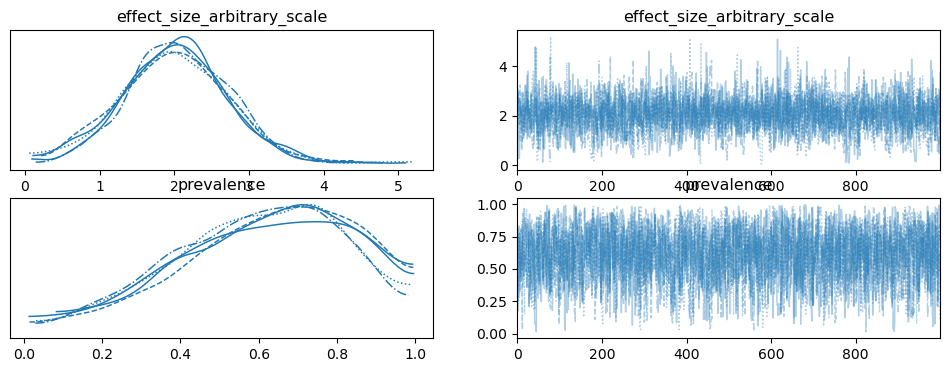

In [6]:
az.plot_trace(idata)
plt.show()

In [7]:
ll = az.stats.stats_utils.get_log_likelihood(idata).values
# sum log-likelihood over observations then convert to likelihood
likelihood_samples = np.exp(ll.sum(-1))
# average log-likelihood over samples to get posterior expectation
likelihood_expected = likelihood_samples.mean()
# and likelihood under Uniform(0, 1) null is always 1.,
print('likelihood:') # so this is like Bayes factor
print(likelihood_expected) 

likelihood:
128.75396239046162


In [8]:
# estimate Bayesian predictive power
np.random.seed(0)
ALPHA = 0.05

def p_cdf(p, delta):
    '''
    cumulative distribution function for p-values
    '''
    Z = norm.isf(p, loc = 0)
    return norm.sf(Z, loc = delta)

deltas = idata.posterior.effect_size_arbitrary_scale
deltas = deltas.values.flatten()
pows = p_cdf(ALPHA, deltas)
print('Posterior predictive power:', pows.mean(), az.hdi(pows, hdi_prob = .9))
pows_post = pows

deltas = expon.rvs(scale = prior_mean, size = 5000)
pows = p_cdf(ALPHA, deltas)
print('Prior predictive power:', pows.mean(), az.hdi(pows, hdi_prob = .9))

Posterior predictive power: 0.6191156268408308 [0.30132139 0.99981561]
Prior predictive power: 0.3954962411952582 [0.05001121 0.96834647]


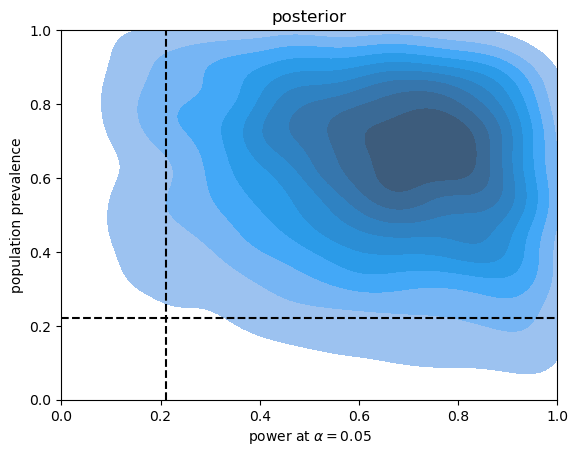

In [9]:
prev = idata.posterior.prevalence.values.flatten()
lower_bound = np.quantile(prev, .05)
df = pd.DataFrame({'prevalence': prev, 'power': pows_post})
sns.kdeplot(data = df, x = 'power', y = 'prevalence', fill = True)
plt.axhline(np.quantile(prev, .05), color = 'black', linestyle = '--')
plt.axvline(np.quantile(pows_post, .05), color = 'black', linestyle = '--')
plt.xlabel(r'power at $\alpha = %.02f$'%ALPHA)
plt.ylabel('population prevalence')
plt.title('posterior')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

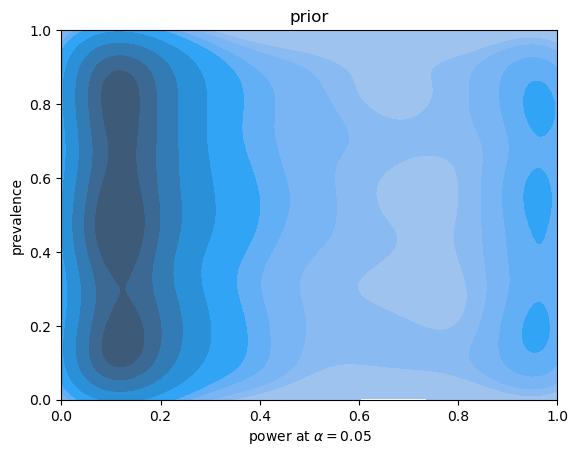

In [10]:
prev = uniform.rvs(size = pows.size)
df = pd.DataFrame({'prevalence': prev, 'power': pows})
sns.kdeplot(data = df, x = 'power', y = 'prevalence', fill = True)
plt.ylabel('prevalence')
plt.xlabel(r'power at $\alpha = %.02f$'%ALPHA)
plt.title('prior')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

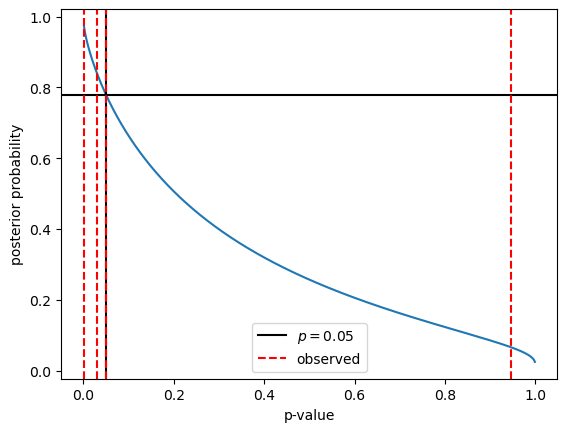

In [11]:
# we can evaluate posterior probability of effect for any pval
post = idata.posterior
delta = post.effect_size_arbitrary_scale.values.flatten()
prev = post.prevalence.values.flatten()

def post_prob(p):
    marginal_lik = p_curve_lik(p, delta) 
    prob_true = (marginal_lik * prev / (marginal_lik*prev + 1.*(1 - prev)))
    return prob_true.mean()
    
ps = np.linspace(0, 1, 1000)[1:-1]
probs = [post_prob(p) for p in ps]
plt.plot(ps, probs)
plt.xlabel('p-value')
plt.ylabel('posterior probability')
alpha = 0.05
plt.axhline(post_prob(alpha), color = 'black')
plt.axvline(alpha, color = 'black', label = r'$p = %.02f$'%alpha)
for p in pvals[:-1]:
    plt.axvline(p, color = 'red', linestyle = '--')
plt.axvline(pvals[-1], color = 'red', linestyle = '--', label = 'observed')
plt.legend()
plt.show()

In [12]:
[post_prob(p) for p in pvals]

[0.9782343174184607,
 0.839347236270089,
 0.7804874535385149,
 0.06653722511563821]

In [13]:
# we can also compare to model in which all subjects
# express the effect/trait 

with pm.Model() as alltrue_model:

    prior_mean = 1.5 # see prior predictive power simulation below
    delta = pm.Exponential('effect_size_arbitrary_scale', 1/prior_mean)
    pcurve_H1 = pm.CustomDist('p', delta, logp = p_curve_loglik, observed = pvals)
    idata_alltrue = pm.sample(
        chains = 5, 
        cores = 5, 
        random_seed = 1,
        idata_kwargs = {'log_likelihood': True},
        target_accept = .95
    )

comp = az.compare({"mixture": idata, r"all $H_1$": idata_alltrue})
comp

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size_arbitrary_scale]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 5 seconds.


Output()

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mixture,0,3.481681,1.687271,0.000000,1.000000e+00,3.137590,0.000000,False,log
all $H_1$,1,1.168253,2.848989,2.313428,2.220446e-16,4.772134,2.247916,False,log


In [14]:
bf_vs_all = np.exp(comp.elpd_loo.loc['mixture'] - comp.elpd_loo.loc[r"all $H_1$"])
bf_vs_null = np.exp(comp.elpd_loo.loc['mixture'])
print('Mixture explains observations %.01f times better than H0,'%bf_vs_null)
print('and %.01f better than model where H1 always true.'%bf_vs_all)

Mixture explains observations 32.5 times better than H0,
and 10.1 better than model where H1 always true.


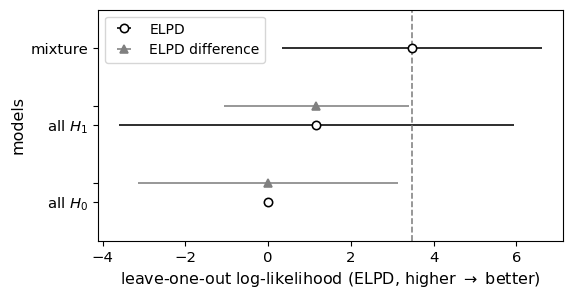

In [15]:
df = comp.copy()
df.loc[r'all $H_0$'] = [
    3, 0, 0, 
    comp.elpd_loo.loc['mixture'], 
    0, 0, 
    comp.se.loc['mixture'], 
    False, 'log'
]
az.plot_compare(df)
plt.ylabel('models')
plt.xlabel(r'leave-one-out log-likelihood (ELPD, higher $\rightarrow$ better)')
plt.title(None)
plt.legend()
plt.show()